In [4]:
import numpy as np
import pandas as pd
from skimage import measure
from scipy import ndimage
from scipy import signal


l = np.arange(480) - 1
l[0] = 0
r = np.arange(480) + 1
r[-1] = r[-2]
b = np.arange(640) - 1
b[0] = 0
u = np.arange(640) + 1
u[-1] = u[-2]


def expand(mask):
    new = mask.copy()
    
    for shift in [l, r]:
        new |= mask[shift, :]
    
    for shift in [b, u]:
        new |= mask[:, shift]

    return new


def find_interesting_pixels(img):
    
    med = ndimage.median_filter(img, size=40)
    mask = img > med + 10
    
    labels = measure.label(expand(mask))
    
    return pd.DataFrame(
        [
            region.centroid
            for region in measure.regionprops(labels)
            if region.area <= 25
        ],
        columns=['r', 'c']
    )

Example.

In [98]:
len(list(pathlib.Path('data/spotGEO/test').glob('*')))

5120

In [5]:
from PIL import Image

img = np.asarray(Image.open('data/spotGEO/train/10/1.png'))
find_interesting_pixels(img)

,r,c
0,1.00,462.000
1,9.00,145.000
2,10.00,152.000
3,11.00,158.500
4,18.25,509.375
...,...,...
94,430.00,378.000
95,433.00,205.000
96,434.00,210.000
97,462.00,509.000


Do it for each image.

In [7]:
import pathlib
from joblib import Parallel, delayed
import tqdm

def f(part, seq, frame):
    img = np.asarray(Image.open(frame))
    return find_interesting_pixels(img).assign(part=part, sequence=int(seq.name), frame=int(frame.stem))

interesting = Parallel(n_jobs=4)(
    delayed(f)(part, seq, frame)
    for part in ['train', 'test']
    for seq in tqdm.tqdm(list(pathlib.Path(f'data/spotGEO/{part}').glob('*')), position=0)
    for frame in seq.glob('*.png')
)

interesting = pd.concat(interesting)
interesting = interesting.set_index(['part', 'sequence', 'frame']).sort_index()
interesting.to_pickle('data/interesting.pkl')

100%|██████████| 5120/5120 [6:30:48<00:00,  4.58s/it]  


Average number of interesting regions per image.

In [20]:
interesting.groupby(['part', 'sequence', 'frame']).size().mean()

60.405456932116515

Percentage of pixels this represents.

In [19]:
f'{len(interesting) / (640 * 480 * 31996):%}'

'0.019663%'

Now let's annotate each interesting region.

In [34]:
import json
import pandas as pd

sats = []

with open('data/spotGEO/train_anno.json') as f:
    for ann in json.load(f):
        for i, coords in enumerate(ann['object_coords']):
            sats.append({
                'sequence': ann['sequence_id'],
                'frame': ann['frame'],
                'satellite': i + 1,
                'r': int(coords[1] + .5),
                'c': int(coords[0] + .5),
            })
    
sats = pd.DataFrame(sats)
sats = sats.set_index(['sequence', 'frame', 'satellite'])
sats.head()

r    c
sequence frame satellite          
1        1     1          237  502
               2          222  490
               3          129  141
         2     1          214  530
               2          199  518

In [54]:
from scipy import optimize 

def assign_labels(interesting, satellites):
    
    # Compute the distance between each satellite and each interesting location,
    # thus forming a bipartite graph
    distances = distance.cdist(satellites, interesting)
    
    # Guess which locations correspond to which satellites
    row_ind, col_ind = optimize.linear_sum_assignment(distances)

    # Each satellite is assigned, but some of them may too distant to be likely
    likely = distances[row_ind, col_ind] < 3
    
    labels = np.full(len(interesting), False, dtype=bool)
    labels[col_ind[likely]] = True
    return labels

Example.

In [55]:
assign_labels(interesting.loc['train', 1, 1], sats.loc[1, 1])

array([False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [83]:
labels = pd.Series(dtype=bool, index=interesting.loc['train'].index)

for (sequence, frame), locations in tqdm.tqdm(interesting.loc['train'].groupby(['sequence', 'frame']), position=0):
    try:
        satellites = sats.loc[sequence, frame]
    except KeyError:
        continue
    labels.loc[sequence, frame] = assign_labels(locations, satellites)

100%|██████████| 6397/6397 [00:07<00:00, 891.85it/s] 


In [90]:
interesting['is_satellite'] = None
interesting.loc['train', 'is_satellite'] = labels.values
interesting.to_pickle('data/interesting.pkl')

In [93]:
interesting.loc['test', 172, 2]

r           c is_satellite
part sequence frame                                     
test 172      2      186.117647  230.941176         None
              2      191.500000  228.000000         None
              2      197.000000  225.636364         None
              2      202.000000  223.000000         None
              2      437.000000  560.000000         None
              2      443.000000  558.000000         None

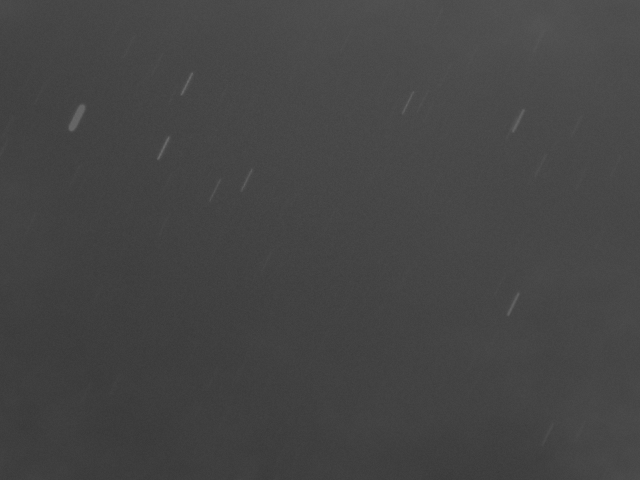

In [94]:
Image.open('data/spotGEO/test/172/1.png')